# Classifying Different Types of Migraines

## Name
### Robert Thompson (rt598@drexel.edu)

# Installing Pyspark and Setting up Environment

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Spark 2.4.5 not found at original link. Using 3.0.3 from apache archive
!wget https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xf spark-3.0.3-bin-hadoop2.7.tgz

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.0.3-bin-hadoop2.7"

!pip install -q findspark
# Explicitly define version here
!pip install pyspark==3.0.3

from google.colab import drive
drive.mount('/content/drive')

--2023-07-16 20:38:43--  https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220400553 (210M) [application/x-gzip]
Saving to: ‘spark-3.0.3-bin-hadoop2.7.tgz.3’

spark-3.0.3-bin-had 100%[===================>] 210.19M  18.5MB/s    in 13s     

2023-07-16 20:38:56 (16.6 MB/s) - ‘spark-3.0.3-bin-hadoop2.7.tgz.3’ saved [220400553/220400553]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries

In [2]:
# Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

# Classification Algorithms
from pyspark.ml.classification import RandomForestClassifier, \
    DecisionTreeClassifier, LogisticRegression

# Algorithm Evaluation
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix

# For Data Visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For Results
import csv

# Creating Spark Session

In [3]:
APP_NAME = "DSCI 632 Final Project: Classifying Migraines"
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
spark

# Loading the Migraine Data

In [4]:
should_infer_schema = "true"
contains_header = "true"
delimiter = ","
file_type = "csv"
input_file_name = "/content/drive/MyDrive/Drexel/DSCI632 Applied Cloud Computing/Final Project/migraine.csv"

df = spark.read.format(file_type) \
  .option("inferSchema", should_infer_schema) \
  .option("header", contains_header) \
  .option("sep", delimiter) \
  .csv(input_file_name)

# Inspecting the Data

## Show All Data

In [5]:
df.show(truncate=False)

+---+--------+---------+--------+---------+---------+------+-----+-----------+-----------+------+-------+---------+----------+-------+--------+----------+--------+------+------+----------+-----------+---+--------------------------+
|Age|Duration|Frequency|Location|Character|Intensity|Nausea|Vomit|Phonophobia|Photophobia|Visual|Sensory|Dysphasia|Dysarthria|Vertigo|Tinnitus|Hypoacusis|Diplopia|Defect|Ataxia|Conscience|Paresthesia|DPF|Type                      |
+---+--------+---------+--------+---------+---------+------+-----+-----------+-----------+------+-------+---------+----------+-------+--------+----------+--------+------+------+----------+-----------+---+--------------------------+
|30 |1       |5        |1       |1        |2        |1     |0    |1          |1          |1     |2      |0        |0         |0      |0       |0         |0       |0     |0     |0         |0          |0  |Typical aura with migraine|
|50 |3       |5        |1       |1        |3        |1     |1    |1     

## Show Data Schema

In [6]:
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Frequency: integer (nullable = true)
 |-- Location: integer (nullable = true)
 |-- Character: integer (nullable = true)
 |-- Intensity: integer (nullable = true)
 |-- Nausea: integer (nullable = true)
 |-- Vomit: integer (nullable = true)
 |-- Phonophobia: integer (nullable = true)
 |-- Photophobia: integer (nullable = true)
 |-- Visual: integer (nullable = true)
 |-- Sensory: integer (nullable = true)
 |-- Dysphasia: integer (nullable = true)
 |-- Dysarthria: integer (nullable = true)
 |-- Vertigo: integer (nullable = true)
 |-- Tinnitus: integer (nullable = true)
 |-- Hypoacusis: integer (nullable = true)
 |-- Diplopia: integer (nullable = true)
 |-- Defect: integer (nullable = true)
 |-- Ataxia: integer (nullable = true)
 |-- Conscience: integer (nullable = true)
 |-- Paresthesia: integer (nullable = true)
 |-- DPF: integer (nullable = true)
 |-- Type: string (nullable = true)



## Number of Rows & Columns

In [7]:
print("Number of Rows:", df.count())
print("Number of Columns:", len(df.columns))

Number of Rows: 400
Number of Columns: 24


## Column Names

In [8]:
df.columns

['Age',
 'Duration',
 'Frequency',
 'Location',
 'Character',
 'Intensity',
 'Nausea',
 'Vomit',
 'Phonophobia',
 'Photophobia',
 'Visual',
 'Sensory',
 'Dysphasia',
 'Dysarthria',
 'Vertigo',
 'Tinnitus',
 'Hypoacusis',
 'Diplopia',
 'Defect',
 'Ataxia',
 'Conscience',
 'Paresthesia',
 'DPF',
 'Type']

## Description of Data Using Pandas

In [9]:
df.toPandas().describe()

,Age,Duration,Frequency,Location,Character,Intensity,Nausea,Vomit,Phonophobia,Photophobia,...,Dysarthria,Vertigo,Tinnitus,Hypoacusis,Diplopia,Defect,Ataxia,Conscience,Paresthesia,DPF
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,...,400.0000,400.000000,400.000000,400.000000,400.000000,400.000000,400.0,400.000000,400.000000,400.000000
mean,31.705000,1.610000,2.365000,0.972500,0.977500,2.47000,0.987500,0.322500,0.977500,0.980000,...,0.0025,0.125000,0.060000,0.015000,0.005000,0.015000,0.0,0.017500,0.007500,0.410000
std,12.139043,0.770964,1.675947,0.268186,0.277825,0.76849,0.111242,0.468019,0.148489,0.140175,...,0.0500,0.331133,0.237784,0.121705,0.070622,0.121705,0.0,0.131289,0.086385,0.492449
min,15.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,22.000000,1.000000,1.000000,1.000000,1.000000,2.00000,1.000000,0.000000,1.000000,1.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,28.000000,1.000000,2.000000,1.000000,1.000000,3.00000,1.000000,0.000000,1.000000,1.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,40.000000,2.000000,4.000000,1.000000,1.000000,3.00000,1.000000,1.000000,1.000000,1.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
max,77.000000,3.000000,8.000000,2.000000,2.000000,3.00000,1.000000,1.000000,1.000000,1.000000,...,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


## Column Unique Values

In [10]:
df.toPandas().nunique()

Age            51
Duration        3
Frequency       8
Location        3
Character       3
Intensity       4
Nausea          2
Vomit           2
Phonophobia     2
Photophobia     2
Visual          5
Sensory         3
Dysphasia       2
Dysarthria      2
Vertigo         2
Tinnitus        2
Hypoacusis      2
Diplopia        2
Defect          2
Ataxia          1
Conscience      2
Paresthesia     2
DPF             2
Type            7
dtype: int64

## Types of Migraines

In [11]:
df.select("Type").distinct().withColumnRenamed("Type", "Types of Migraines").show(truncate=False)

+-----------------------------+
|Types of Migraines           |
+-----------------------------+
|Sporadic hemiplegic migraine |
|Basilar-type aura            |
|Other                        |
|Familial hemiplegic migraine |
|Typical aura with migraine   |
|Typical aura without migraine|
|Migraine without aura        |
+-----------------------------+



## Average Age of Migraines

In [12]:
df.agg(avg(col("Age"))).withColumnRenamed("avg(Age)", "Average Age of Migraines").show()

+------------------------+
|Average Age of Migraines|
+------------------------+
|                  31.705|
+------------------------+



## Average Duration of Migraines

In [13]:
df.agg(avg(col("Duration"))).withColumnRenamed("avg(Duration)", "Average Duration of Migraines").show()

+-----------------------------+
|Average Duration of Migraines|
+-----------------------------+
|                         1.61|
+-----------------------------+



## Average Frequency of Migraines

In [14]:
df.agg(avg(col("Frequency"))).withColumnRenamed("avg(Frequency)", "Average Frequency of Migraines").show()

+------------------------------+
|Average Frequency of Migraines|
+------------------------------+
|                         2.365|
+------------------------------+



# Cleaning the Data

## Removing Nulls or NAs

In [15]:
print("Count BEFORE Removing NA:",df.count())
df = df.na.drop()
print("Count AFTER Removing NA:",df.count())

Count BEFORE Removing NA: 400
Count AFTER Removing NA: 400


## Dropping 'Ataxia' Column

In [16]:
# There is only one unique value for the 'Ataxia' column
df2 = df.drop("Ataxia")
df2.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Frequency: integer (nullable = true)
 |-- Location: integer (nullable = true)
 |-- Character: integer (nullable = true)
 |-- Intensity: integer (nullable = true)
 |-- Nausea: integer (nullable = true)
 |-- Vomit: integer (nullable = true)
 |-- Phonophobia: integer (nullable = true)
 |-- Photophobia: integer (nullable = true)
 |-- Visual: integer (nullable = true)
 |-- Sensory: integer (nullable = true)
 |-- Dysphasia: integer (nullable = true)
 |-- Dysarthria: integer (nullable = true)
 |-- Vertigo: integer (nullable = true)
 |-- Tinnitus: integer (nullable = true)
 |-- Hypoacusis: integer (nullable = true)
 |-- Diplopia: integer (nullable = true)
 |-- Defect: integer (nullable = true)
 |-- Conscience: integer (nullable = true)
 |-- Paresthesia: integer (nullable = true)
 |-- DPF: integer (nullable = true)
 |-- Type: string (nullable = true)



In [17]:
df2.toPandas().nunique()

Age            51
Duration        3
Frequency       8
Location        3
Character       3
Intensity       4
Nausea          2
Vomit           2
Phonophobia     2
Photophobia     2
Visual          5
Sensory         3
Dysphasia       2
Dysarthria      2
Vertigo         2
Tinnitus        2
Hypoacusis      2
Diplopia        2
Defect          2
Conscience      2
Paresthesia     2
DPF             2
Type            7
dtype: int64

# Data Visualization

In [18]:
pandas_df = df2.toPandas()

## Types of Migraines

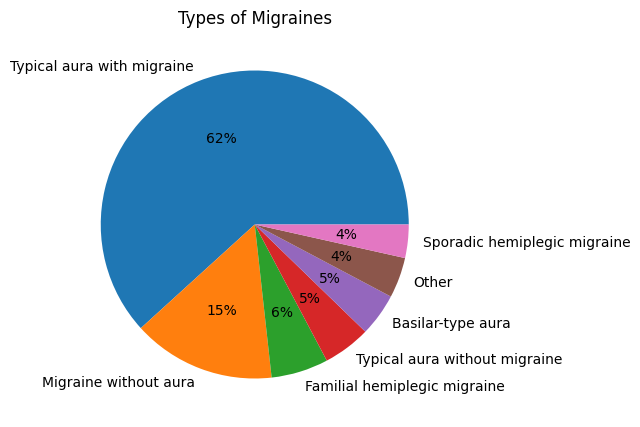

In [19]:
unique_types = df2.groupBy("Type").count().orderBy("count", ascending=False)
unique_types_df = unique_types.limit(unique_types.count()).toPandas()

labels = unique_types_df["Type"]
data = unique_types_df["count"]

plt.figure(figsize=(5, 5))
plt.title("Types of Migraines")
plt.pie(data, labels = labels, autopct='%.0f%%')
plt.show()

## Age Histogram

[Text(0.5, 1.0, 'Age Histogram')]

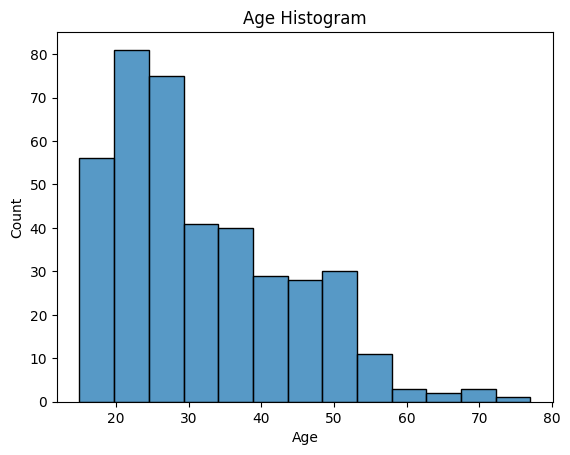

In [20]:
sns.histplot(pandas_df["Age"]).set(title="Age Histogram")

## Duration of Migraine Symptoms

[Text(0.5, 1.0, 'Duration of Migraine Symptoms')]

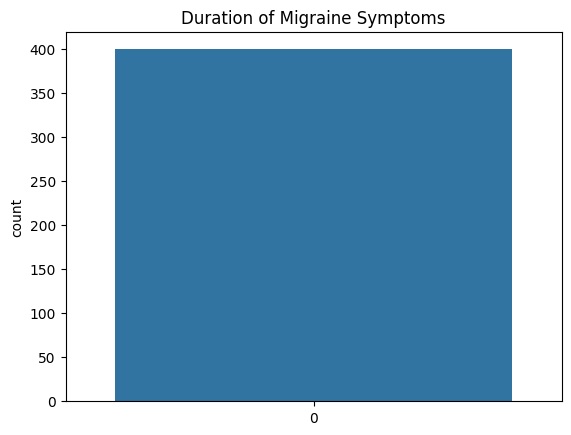

In [21]:
sns.countplot(pandas_df["Duration"]).set(title="Duration of Migraine Symptoms")

## Frequency of Migraines

[Text(0.5, 1.0, 'Frequency of Migraines')]

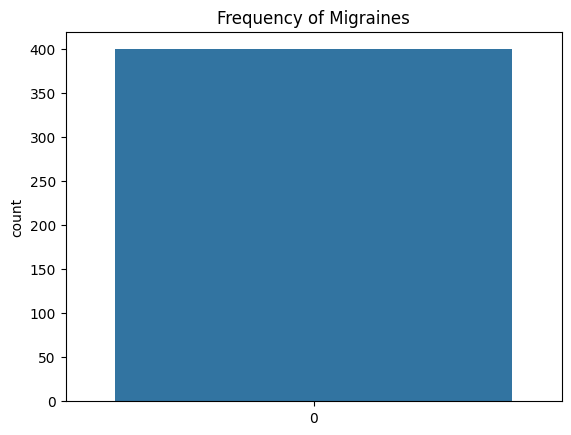

In [22]:
sns.countplot(pandas_df["Frequency"]).set(title="Frequency of Migraines")

# Algorithm Application

## Helpful CSV Function

In [23]:
model_results = []
output_file_name = "/content/drive/MyDrive/Drexel/DSCI632 Applied Cloud Computing/Final Project/migraine_classification_results.csv"

def write_results_to_csv(data):
  header = ['model', 'parameter tuned', 'data', 'accuracy', 'recall', \
            'precision', 'f1-score']

  with open(output_file_name, 'w', encoding='UTF8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=header)
        writer.writeheader()
        writer.writerows(data)

## Pre-Process Data for Pipeline

In [24]:
# Convert Type to an Index and change to 'label'
type_indexer = StringIndexer(inputCol="Type", outputCol="label")

# Assemble Features Columns
feature_columns = ["Age", "Duration", "Frequency", "Location", "Character", \
                   "Intensity", "Nausea", "Vomit", "Phonophobia", "Visual", \
                   "Sensory", "Dysphasia", "Dysarthria", "Vertigo", "Tinnitus", \
                   "Hypoacusis", "Diplopia", "Defect", "Conscience", "Paresthesia", \
                   "DPF"]
# Create our Feature Vector
feature_vector = VectorAssembler(inputCols=feature_columns, outputCol="features")

## Split Train & Test

In [25]:
seed = 10  # Set seed for reproducibility
train, test = df2.randomSplit([0.8, 0.2], seed=seed)
print("Total Dataset Count:", df2.count())
print("Train Dataset Count:", train.count())
print("Test Dataset Count:", test.count())

Total Dataset Count: 400
Train Dataset Count: 324
Test Dataset Count: 76


## Random Forest Classifier

In [26]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label',\
                            impurity = "entropy")

pipeline_rf = Pipeline(stages=[type_indexer, feature_vector, rf])
pipelineModel_rf = pipeline_rf.fit(train)

### Train Data Evaluation

In [27]:
train_preds = pipelineModel_rf.transform(train)
rf_train_preds_rdd = train_preds.select("label", "prediction").rdd.map(tuple)

rf_train_preds_metrics = MulticlassMetrics(rf_train_preds_rdd)

rf_train_results = {
    "model": "Random Forest",
    "parameter tuned": "impurity = entropy",
    "data": "Train",
    "accuracy": float("{:.3f}".format(rf_train_preds_metrics.accuracy)),
    "recall": float("{:.3f}".format(rf_train_preds_metrics.recall(1.0))),
    "precision": float("{:.3f}".format(rf_train_preds_metrics.weightedPrecision)),
    "f1-score": float("{:.3f}".format(rf_train_preds_metrics.fMeasure(1.0, 1.0)))
}
model_results.append(rf_train_results)

print("Random Forest Train Data - Classification Report:")
print("Accuracy:", float("{:.3f}".format(rf_train_preds_metrics.accuracy)))
print("Recall:", float("{:.3f}".format(rf_train_preds_metrics.recall(1.0))))
print("Precision:", float("{:.3f}".format(rf_train_preds_metrics.weightedPrecision)))
print("F1-Score:", float("{:.3f}".format(rf_train_preds_metrics.fMeasure(1.0, 1.0))))

print("\n")

y_train = train_preds.select("label").collect()
y_train_preds = train_preds.select("prediction").collect()

print("Random Forest Train Data - Confusion Matrix")
print(confusion_matrix(y_train, y_train_preds))

Random Forest Train Data - Classification Report:
Accuracy: 0.935
Recall: 0.981
Precision: 0.968
F1-Score: 0.99


Random Forest Train Data - Confusion Matrix
[[202   0   0   0   0   0   0]
 [  0  51   0   0   0   0   0]
 [ 10   0   6   0   0   0   0]
 [  0   0   0  16   0   0   0]
 [  2   0   0   0  11   0   0]
 [  1   1   0   0   0  11   0]
 [  7   0   0   0   0   0   6]]


### Test Data Evaluation

In [28]:
test_preds = pipelineModel_rf.transform(test)
rf_test_preds_rdd = test_preds.select("label", "prediction").rdd.map(tuple)

rf_test_preds_metrics = MulticlassMetrics(rf_test_preds_rdd)

rf_test_results = {
    "model": "Random Forest",
    "parameter tuned": "impurity = entropy",
    "data": "Test",
    "accuracy": float("{:.3f}".format(rf_test_preds_metrics.accuracy)),
    "recall": float("{:.3f}".format(rf_test_preds_metrics.recall(1.0))),
    "precision": float("{:.3f}".format(rf_test_preds_metrics.weightedPrecision)),
    "f1-score": float("{:.3f}".format(rf_test_preds_metrics.fMeasure(1.0, 1.0)))
}
model_results.append(rf_test_results)

print("Random Forest Test Data - Classification Report")
print("Accuracy:", float("{:.3f}".format(rf_test_preds_metrics.accuracy)))
print("Recall:", float("{:.3f}".format(rf_test_preds_metrics.recall(1.0))))
print("Precision:", float("{:.3f}".format(rf_test_preds_metrics.weightedPrecision)))
print("F1-Score:", float("{:.3f}".format(rf_test_preds_metrics.fMeasure(1.0, 1.0))))

print("\n")

y_test = test_preds.select("label").collect()
y_test_preds = test_preds.select("prediction").collect()

print("Random Forest Test Data - Confusion Matrix")
print(confusion_matrix(y_test, y_test_preds))

Random Forest Test Data - Classification Report
Accuracy: 0.829
Recall: 0.818
Precision: 0.963
F1-Score: 0.9


Random Forest Test Data - Confusion Matrix
[[45  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0]
 [ 7  0  1  0  0  0  0]
 [ 0  0  0  4  0  0  0]
 [ 1  1  0  0  3  0  0]
 [ 2  1  0  0  0  1  0]
 [ 1  0  0  0  0  0  0]]


## Random Forest Classifier - Hyperparameter Tuned

In [29]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', \
                            maxDepth = 10, impurity = "entropy", numTrees = 25)

pipeline_rf = Pipeline(stages=[type_indexer, feature_vector, rf])
pipelineModel_rf = pipeline_rf.fit(train)

### Train Data Evaluation

In [30]:
train_preds = pipelineModel_rf.transform(train)
rf_train_preds_rdd = train_preds.select("label", "prediction").rdd.map(tuple)

rf_ht_train_preds_metrics = MulticlassMetrics(rf_train_preds_rdd)

rf_ht_train_results = {
    "model": "Random Forest",
    "parameter tuned": "maxDepth = 10, impurity = entropy, numTrees = 25",
    "data": "Train",
    "accuracy": float("{:.3f}".format(rf_ht_train_preds_metrics.accuracy)),
    "recall": float("{:.3f}".format(rf_ht_train_preds_metrics.recall(1.0))),
    "precision": float("{:.3f}".format(rf_ht_train_preds_metrics.weightedPrecision)),
    "f1-score": float("{:.3f}".format(rf_ht_train_preds_metrics.fMeasure(1.0, 1.0)))
}
model_results.append(rf_ht_train_results)

print("Random Forest Hyperparameter Tuned Train Data - Classification Report:")
print("Accuracy:", float("{:.3f}".format(rf_ht_train_preds_metrics.accuracy)))
print("Recall:", float("{:.3f}".format(rf_ht_train_preds_metrics.recall(1.0))))
print("Precision:", float("{:.3f}".format(rf_ht_train_preds_metrics.weightedPrecision)))
print("F1-Score:", float("{:.3f}".format(rf_ht_train_preds_metrics.fMeasure(1.0, 1.0))))

print("\n")

y_train = train_preds.select("label").collect()
y_train_preds = train_preds.select("prediction").collect()

print("Random Forest Train Data - Confusion Matrix")
print(confusion_matrix(y_train, y_train_preds))

Random Forest Hyperparameter Tuned Train Data - Classification Report:
Accuracy: 0.978
Recall: 0.981
Precision: 0.983
F1-Score: 0.99


Random Forest Train Data - Confusion Matrix
[[202   0   0   0   0   0   0]
 [  0  51   0   0   0   0   0]
 [  3   0  13   0   0   0   0]
 [  0   0   0  16   0   0   0]
 [  0   0   0   0  13   0   0]
 [  0   1   0   0   0  12   0]
 [  3   0   0   0   0   0  10]]


### Test Data Evaluation

In [31]:
test_preds = pipelineModel_rf.transform(test)
rf_test_preds_rdd = test_preds.select("label", "prediction").rdd.map(tuple)

rf_ht_test_preds_metrics = MulticlassMetrics(rf_test_preds_rdd)

rf_ht_test_results = {
    "model": "Random Forest",
    "parameter tuned": "maxDepth = 10, impurity = entropy, numTrees = 25",
    "data": "Test",
    "accuracy": float("{:.3f}".format(rf_ht_test_preds_metrics.accuracy)),
    "recall": float("{:.3f}".format(rf_ht_test_preds_metrics.recall(1.0))),
    "precision": float("{:.3f}".format(rf_ht_test_preds_metrics.weightedPrecision)),
    "f1-score": float("{:.3f}".format(rf_ht_test_preds_metrics.fMeasure(1.0, 1.0)))
}
model_results.append(rf_ht_test_results)

print("Random Forest Hyperparameter Tuned Test Data - Classification Report")
print("Accuracy:", float("{:.3f}".format(rf_ht_test_preds_metrics.accuracy)))
print("Recall:", float("{:.3f}".format(rf_ht_test_preds_metrics.recall(1.0))))
print("Precision:", float("{:.3f}".format(rf_ht_test_preds_metrics.weightedPrecision)))
print("F1-Score:", float("{:.3f}".format(rf_ht_test_preds_metrics.fMeasure(1.0, 1.0))))

print("\n")

y_test = test_preds.select("label").collect()
y_test_preds = test_preds.select("prediction").collect()

print("Random Forest Test Data - Confusion Matrix")
print(confusion_matrix(y_test, y_test_preds))

Random Forest Hyperparameter Tuned Test Data - Classification Report
Accuracy: 0.855
Recall: 0.9
Precision: 0.935
F1-Score: 0.947


Random Forest Test Data - Confusion Matrix
[[45  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0]
 [ 6  0  2  0  0  0  0]
 [ 0  0  0  4  0  0  0]
 [ 0  1  2  0  2  0  0]
 [ 1  0  0  0  0  3  0]
 [ 1  0  0  0  0  0  0]]


## Decision Tree Classifier

In [32]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', \
                            impurity = "entropy")

pipeline_dt = Pipeline(stages=[type_indexer, feature_vector, dt])
pipelineModel_dt = pipeline_dt.fit(train)

### Train Data Evaluation

In [33]:
train_preds = pipelineModel_dt.transform(train)
dt_train_preds_rdd = train_preds.select("label", "prediction").rdd.map(tuple)

dt_train_preds_metrics = MulticlassMetrics(dt_train_preds_rdd)

dt_train_results = {
    "model": "Decision Tree",
    "parameter tuned": "impurity = entropy",
    "data": "Train",
    "accuracy": float("{:.3f}".format(dt_train_preds_metrics.accuracy)),
    "recall": float("{:.3f}".format(dt_train_preds_metrics.recall(1.0))),
    "precision": float("{:.3f}".format(dt_train_preds_metrics.weightedPrecision)),
    "f1-score": float("{:.3f}".format(dt_train_preds_metrics.fMeasure(1.0, 1.0)))
}
model_results.append(dt_train_results)

print("Decision Tree Train Data - Classification Report:")
print("Accuracy:", float("{:.3f}".format(dt_train_preds_metrics.accuracy)))
print("Recall:", float("{:.3f}".format(dt_train_preds_metrics.recall(1.0))))
print("Precision:", float("{:.3f}".format(dt_train_preds_metrics.weightedPrecision)))
print("F1-Score:", float("{:.3f}".format(dt_train_preds_metrics.fMeasure(1.0, 1.0))))

print("\n")

y_train = train_preds.select("label").collect()
y_train_preds = train_preds.select("prediction").collect()

print("Decision Tree Train Data - Confusion Matrix")
print(confusion_matrix(y_train, y_train_preds))

Decision Tree Train Data - Classification Report:
Accuracy: 0.898
Recall: 0.962
Precision: 0.943
F1-Score: 0.981


Decision Tree Train Data - Confusion Matrix
[[201   0   0   0   0   0   1]
 [  0  51   0   0   0   0   0]
 [  9   0   7   0   0   0   0]
 [  0   0   0  16   0   0   0]
 [  2   0   0   0   8   0   3]
 [  4   2   3   0   2   2   0]
 [  5   0   0   0   2   0   6]]


### Test Data Evaluation

In [34]:
test_preds = pipelineModel_dt.transform(test)
dt_test_preds_rdd = test_preds.select("label", "prediction").rdd.map(tuple)

dt_test_preds_metrics = MulticlassMetrics(dt_test_preds_rdd)

dt_test_results = {
    "model": "Decision Tree",
    "parameter tuned": "impurity = entropy",
    "data": "Test",
    "accuracy": float("{:.3f}".format(dt_test_preds_metrics.accuracy)),
    "recall": float("{:.3f}".format(dt_test_preds_metrics.recall(1.0))),
    "precision": float("{:.3f}".format(dt_test_preds_metrics.weightedPrecision)),
    "f1-score": float("{:.3f}".format(dt_test_preds_metrics.fMeasure(1.0, 1.0)))
}
model_results.append(dt_test_results)

print("Decision Tree Test Data - Classification Report")
print("Accuracy:", float("{:.3f}".format(dt_test_preds_metrics.accuracy)))
print("Recall:", float("{:.3f}".format(dt_test_preds_metrics.recall(1.0))))
print("Precision:", float("{:.3f}".format(dt_test_preds_metrics.weightedPrecision)))
print("F1-Score:", float("{:.3f}".format(dt_test_preds_metrics.fMeasure(1.0, 1.0))))

print("\n")

y_test = test_preds.select("label").collect()
y_test_preds = test_preds.select("prediction").collect()

print("Decision Tree Test Data - Confusion Matrix")
print(confusion_matrix(y_test, y_test_preds))

Decision Tree Test Data - Classification Report
Accuracy: 0.776
Recall: 0.8
Precision: 0.902
F1-Score: 0.842


Decision Tree Test Data - Confusion Matrix
[[44  0  0  0  0  0  1]
 [ 0  8  1  0  0  0  0]
 [ 5  0  3  0  0  0  0]
 [ 0  0  0  4  0  0  0]
 [ 4  1  0  0  0  0  0]
 [ 2  1  0  0  1  0  0]
 [ 0  0  1  0  0  0  0]]


## Decision Tree Classifier - Hyperparameter Tuned

In [35]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', \
                            maxDepth = 10, impurity = "entropy")

pipeline_dt = Pipeline(stages=[type_indexer, feature_vector, dt])
pipelineModel_dt = pipeline_dt.fit(train)

### Train Data Evaluation

In [36]:
train_preds = pipelineModel_dt.transform(train)
dt_ht_train_preds_rdd = train_preds.select("label", "prediction").rdd.map(tuple)

dt_ht_train_preds_metrics = MulticlassMetrics(dt_ht_train_preds_rdd)

dt_ht_train_results = {
    "model": "Decision Tree",
    "parameter tuned": "maxDepth = 10, impurity = entropy",
    "data": "Train",
    "accuracy": float("{:.3f}".format(dt_ht_train_preds_metrics.accuracy)),
    "recall": float("{:.3f}".format(dt_ht_train_preds_metrics.recall(1.0))),
    "precision": float("{:.3f}".format(dt_ht_train_preds_metrics.weightedPrecision)),
    "f1-score": float("{:.3f}".format(dt_ht_train_preds_metrics.fMeasure(1.0, 1.0)))
}
model_results.append(dt_ht_train_results)

print("Decision Tree Hyperparameter Tuned Train Data - Classification Report:")
print("Accuracy:", float("{:.3f}".format(dt_ht_train_preds_metrics.accuracy)))
print("Recall:", float("{:.3f}".format(dt_ht_train_preds_metrics.recall(1.0))))
print("Precision:", float("{:.3f}".format(dt_ht_train_preds_metrics.weightedPrecision)))
print("F1-Score:", float("{:.3f}".format(dt_ht_train_preds_metrics.fMeasure(1.0, 1.0))))

print("\n")

y_train = train_preds.select("label").collect()
y_train_preds = train_preds.select("prediction").collect()

print("Decision Tree Train Data - Confusion Matrix")
print(confusion_matrix(y_train, y_train_preds))

Decision Tree Hyperparameter Tuned Train Data - Classification Report:
Accuracy: 0.994
Recall: 1.0
Precision: 0.995
F1-Score: 1.0


Decision Tree Train Data - Confusion Matrix
[[202   0   0   0   0   0   0]
 [  0  51   0   0   0   0   0]
 [  0   0  16   0   0   0   0]
 [  0   0   0  16   0   0   0]
 [  0   0   0   0  13   0   0]
 [  0   0   0   0   0  13   0]
 [  2   0   0   0   0   0  11]]


### Test Data Evaluation

In [37]:
test_preds = pipelineModel_dt.transform(test)
dt_ht_test_preds_rdd = test_preds.select("label", "prediction").rdd.map(tuple)

dt_ht_test_preds_metrics = MulticlassMetrics(dt_ht_test_preds_rdd)

dt_ht_test_results = {
    "model": "Decision Tree",
    "parameter tuned": "maxDepth = 10, impurity = entropy",
    "data": "Test",
    "accuracy": float("{:.3f}".format(dt_ht_test_preds_metrics.accuracy)),
    "recall": float("{:.3f}".format(dt_ht_test_preds_metrics.recall(1.0))),
    "precision": float("{:.3f}".format(dt_ht_test_preds_metrics.weightedPrecision)),
    "f1-score": float("{:.3f}".format(dt_ht_test_preds_metrics.fMeasure(1.0, 1.0)))
}
model_results.append(dt_ht_test_results)

print("Decision Tree Hyperparameter Tuned Test Data - Classification Report")
print("Accuracy:", float("{:.3f}".format(dt_ht_test_preds_metrics.accuracy)))
print("Recall:", float("{:.3f}".format(dt_ht_test_preds_metrics.recall(1.0))))
print("Precision:", float("{:.3f}".format(dt_ht_test_preds_metrics.weightedPrecision)))
print("F1-Score:", float("{:.3f}".format(dt_ht_test_preds_metrics.fMeasure(1.0, 1.0))))

print("\n")

y_test = test_preds.select("label").collect()
y_test_preds = test_preds.select("prediction").collect()

print("Decision Tree Test Data - Confusion Matrix")
print(confusion_matrix(y_test, y_test_preds))

Decision Tree Hyperparameter Tuned Test Data - Classification Report
Accuracy: 0.803
Recall: 0.889
Precision: 0.823
F1-Score: 0.889


Decision Tree Test Data - Confusion Matrix
[[41  0  3  0  1  0  0]
 [ 0  8  1  0  0  0  0]
 [ 4  0  2  0  0  2  0]
 [ 0  0  0  4  0  0  0]
 [ 0  1  0  0  4  0  0]
 [ 2  0  0  0  0  2  0]
 [ 0  0  1  0  0  0  0]]


## Logistic Regression

In [38]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label')

pipeline_lr = Pipeline(stages=[type_indexer, feature_vector, lr])
pipelineModel_lr = pipeline_lr.fit(train)

### Train Data Evaluation

In [39]:
train_preds = pipelineModel_lr.transform(train)
lr_train_preds_rdd = train_preds.select("label", "prediction").rdd.map(tuple)

lr_train_preds_metrics = MulticlassMetrics(lr_train_preds_rdd)

lr_train_results = {
    "model": "Logistic Regression",
    "parameter tuned": "default",
    "data": "Train",
    "accuracy": float("{:.3f}".format(lr_train_preds_metrics.accuracy)),
    "recall": float("{:.3f}".format(lr_train_preds_metrics.recall(1.0))),
    "precision": float("{:.3f}".format(lr_train_preds_metrics.weightedPrecision)),
    "f1-score": float("{:.3f}".format(lr_train_preds_metrics.fMeasure(1.0, 1.0)))
}
model_results.append(lr_train_results)

print("Logistic Regression Train Data - Classification Report:")
print("Accuracy:", float("{:.3f}".format(lr_train_preds_metrics.accuracy)))
print("Recall:", float("{:.3f}".format(lr_train_preds_metrics.recall(1.0))))
print("Precision:", float("{:.3f}".format(lr_train_preds_metrics.weightedPrecision)))
print("F1-Score:", float("{:.3f}".format(lr_train_preds_metrics.fMeasure(1.0, 1.0))))

print("\n")

y_train = train_preds.select("label").collect()
y_train_preds = train_preds.select("prediction").collect()

print("Logistic Regression Train Data - Confusion Matrix")
print(confusion_matrix(y_train, y_train_preds))

Logistic Regression Train Data - Classification Report:
Accuracy: 0.978
Recall: 1.0
Precision: 0.982
F1-Score: 1.0


Logistic Regression Train Data - Confusion Matrix
[[201   0   0   0   0   0   1]
 [  0  51   0   0   0   0   0]
 [  2   0  14   0   0   0   0]
 [  0   0   0  16   0   0   0]
 [  0   0   0   0  13   0   0]
 [  0   0   0   0   0  13   0]
 [  4   0   0   0   0   0   9]]


### Test Data Evaluation

In [40]:
test_preds = pipelineModel_lr.transform(test)
lr_test_preds_rdd = test_preds.select("label", "prediction").rdd.map(tuple)

lr_test_preds_metrics = MulticlassMetrics(lr_test_preds_rdd)

lr_test_results = {
    "model": "Logistic Regression",
    "parameter tuned": "default",
    "data": "Test",
    "accuracy": float("{:.3f}".format(lr_test_preds_metrics.accuracy)),
    "recall": float("{:.3f}".format(lr_test_preds_metrics.recall(1.0))),
    "precision": float("{:.3f}".format(lr_test_preds_metrics.weightedPrecision)),
    "f1-score": float("{:.3f}".format(lr_test_preds_metrics.fMeasure(1.0, 1.0)))
}
model_results.append(lr_test_results)

print("Logistic Regression Test Data - Classification Report")
print("Accuracy:", float("{:.3f}".format(lr_test_preds_metrics.accuracy)))
print("Recall:", float("{:.3f}".format(lr_test_preds_metrics.recall(1.0))))
print("Precision:", float("{:.3f}".format(lr_test_preds_metrics.weightedPrecision)))
print("F1-Score:", float("{:.3f}".format(lr_test_preds_metrics.fMeasure(1.0, 1.0))))

print("\n")

y_test = test_preds.select("label").collect()
y_test_preds = test_preds.select("prediction").collect()

print("Logistic Regression Test Data - Confusion Matrix")
print(confusion_matrix(y_test, y_test_preds))

Logistic Regression Test Data - Classification Report
Accuracy: 0.882
Recall: 1.0
Precision: 0.9
F1-Score: 0.941


Logistic Regression Test Data - Confusion Matrix
[[43  0  2  0  0  0  0]
 [ 0  8  0  0  0  1  0]
 [ 5  0  3  0  0  0  0]
 [ 0  0  0  4  0  0  0]
 [ 0  0  1  0  4  0  0]
 [ 0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  1]]


## Logistic Regression - Hyperparameter Tuned

In [41]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', \
                        maxIter = 1000)

pipeline_lr = Pipeline(stages=[type_indexer, feature_vector, lr])
pipelineModel_lr = pipeline_lr.fit(train)

### Train Data Evaluation

In [42]:
train_preds = pipelineModel_lr.transform(train)
lr_ht_train_preds_rdd = train_preds.select("label", "prediction").rdd.map(tuple)

lr_ht_train_preds_metrics = MulticlassMetrics(lr_ht_train_preds_rdd)

lr_ht_train_results = {
    "model": "Logistic Regression",
    "parameter tuned": "maxIter = 1000",
    "data": "Train",
    "accuracy": float("{:.3f}".format(lr_ht_train_preds_metrics.accuracy)),
    "recall": float("{:.3f}".format(lr_ht_train_preds_metrics.recall(1.0))),
    "precision": float("{:.3f}".format(lr_ht_train_preds_metrics.weightedPrecision)),
    "f1-score": float("{:.3f}".format(lr_ht_train_preds_metrics.fMeasure(1.0, 1.0)))
}
model_results.append(lr_ht_train_results)

print("Logistic Regression Hyperparameter Tuned Train Data - Classification Report:")
print("Accuracy:", float("{:.3f}".format(lr_ht_train_preds_metrics.accuracy)))
print("Recall:", float("{:.3f}".format(lr_ht_train_preds_metrics.recall(1.0))))
print("Precision:", float("{:.3f}".format(lr_ht_train_preds_metrics.weightedPrecision)))
print("F1-Score:", float("{:.3f}".format(lr_ht_train_preds_metrics.fMeasure(1.0, 1.0))))

print("\n")

y_train = train_preds.select("label").collect()
y_train_preds = train_preds.select("prediction").collect()

print("Logistic Regression Train Data - Confusion Matrix")
print(confusion_matrix(y_train, y_train_preds))

Logistic Regression Hyperparameter Tuned Train Data - Classification Report:
Accuracy: 0.988
Recall: 1.0
Precision: 0.989
F1-Score: 1.0


Logistic Regression Train Data - Confusion Matrix
[[201   0   0   0   0   0   1]
 [  0  51   0   0   0   0   0]
 [  0   0  16   0   0   0   0]
 [  0   0   0  16   0   0   0]
 [  0   0   0   0  13   0   0]
 [  0   0   0   0   0  13   0]
 [  3   0   0   0   0   0  10]]


### Test Data Evaluation

In [43]:
test_preds = pipelineModel_lr.transform(test)
lr_ht_test_preds_rdd = test_preds.select("label", "prediction").rdd.map(tuple)

lr_ht_test_preds_metrics = MulticlassMetrics(lr_ht_test_preds_rdd)

lr_ht_test_results = {
    "model": "Logistic Regression",
    "parameter tuned": "maxIter = 1000",
    "data": "Test",
    "accuracy": float("{:.3f}".format(lr_ht_test_preds_metrics.accuracy)),
    "recall": float("{:.3f}".format(lr_ht_test_preds_metrics.recall(1.0))),
    "precision": float("{:.3f}".format(lr_ht_test_preds_metrics.weightedPrecision)),
    "f1-score": float("{:.3f}".format(lr_ht_test_preds_metrics.fMeasure(1.0, 1.0)))
}
model_results.append(lr_ht_test_results)

print("Logistic Regression Hyperparameter Tuned Test Data - Classification Report")
print("Accuracy:", float("{:.3f}".format(lr_ht_test_preds_metrics.accuracy)))
print("Recall:", float("{:.3f}".format(lr_ht_test_preds_metrics.recall(1.0))))
print("Precision:", float("{:.3f}".format(lr_ht_test_preds_metrics.weightedPrecision)))
print("F1-Score:", float("{:.3f}".format(lr_ht_test_preds_metrics.fMeasure(1.0, 1.0))))

print("\n")

y_test = test_preds.select("label").collect()
y_test_preds = test_preds.select("prediction").collect()

print("Logistic Regression Test Data - Confusion Matrix")
print(confusion_matrix(y_test, y_test_preds))

Logistic Regression Hyperparameter Tuned Test Data - Classification Report
Accuracy: 0.829
Recall: 1.0
Precision: 0.845
F1-Score: 0.941


Logistic Regression Test Data - Confusion Matrix
[[41  0  3  0  0  1  0]
 [ 0  8  0  0  0  1  0]
 [ 5  0  2  0  1  0  0]
 [ 0  0  0  4  0  0  0]
 [ 0  0  1  0  4  0  0]
 [ 1  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  1]]


## Write Results to CSV

In [44]:
write_results_to_csv(model_results)